In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import environments
import pandas as pd
import models.utils
from tqdm import tqdm
from models import ValueIterationNetwork, MCTS, GridWorldNode
from models.utils import softmax


# Example 1: Diffusion (random transitions) with Rewards in corners

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20
grid_shape = (n_rows, n_columns)

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0
R[n_columns-1] = 1.0 
R[-1] = 1.0
R[-n_columns] = 1.0

gamma = 0.8
iterations = 10

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)


  0%|          | 0/10 [00:00<?, ?it/s]

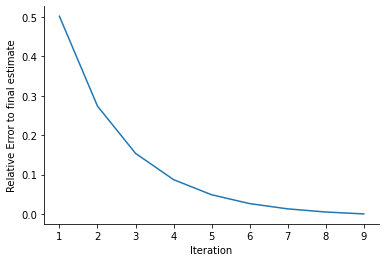

In [3]:
error = np.linalg.norm(V -  np.tile(V[-1,:], (iterations, 1)), axis=1)
plt.plot(np.arange(1, len(error)), error[1:] / np.max(error))
plt.ylabel('Relative Error to final estimate')
plt.xlabel('Iteration')
sns.despine()

Text(0.5, 1.0, 'First value estimate')

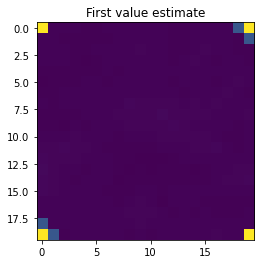

In [4]:
plt.imshow(V[0, :].reshape(grid_shape), cmap='viridis')
plt.title('First value estimate')
# plt.savefig('images/2dDrift_v0.pdf', dpi=300)

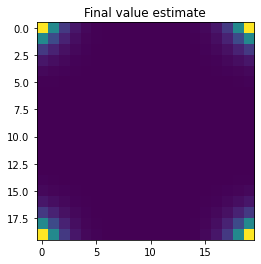

In [5]:
plt.title('Final value estimate')
plt.imshow(V[-1, :].reshape(grid_shape), cmap='viridis', vmin=0, vmax=1)
# plt.savefig('images/2dDrift_vf.pdf', dpi=300)

# Example 2: 1D Diffusion with Reward on one end

In [6]:
# define the enviornment
n_rows, n_columns = 1, 20

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0

iterations = 10000

# helper function
def plot_1d_value_estimates(value_estimates, gamma, ax=None, legend=True):
    if ax is None:
        _, ax = plt.subplots()
    
    n_steps = 7
    cc = sns.color_palette('viridis_r', n_colors=n_steps)
    for ii in range(0, n_steps):
        ax.plot(value_estimates[2**ii, :], label=f'{2**ii}', c=cc[ii])
    ax.plot(value_estimates[-1, :], label=f'10,000', c='k', ls='--')
    ax.set_ylabel('Estimated Value')
    ax.set_xlabel('Distance from left edge')
    if legend:
        ax.legend(title='Iteration')
    ax.set_title(r'$\gamma={}$'.format(gamma))
    ax.set_xticks([ii for ii in range(0, n_columns +1, 4)])
#     sns.despine(trim=True)

def value_estimate_error(value_estimates):
    return np.linalg.norm(value_estimates[:-1:] - np.tile(value_estimates[-1,:], (iterations-1, 1)), axis=1)



  0%|          | 0/10000 [00:00<?, ?it/s]

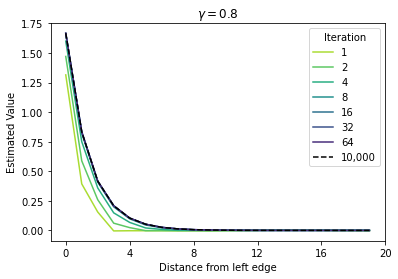

In [7]:
gamma = 0.8

# call the value iteration network
Q, V_g80 = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g08 = value_estimate_error(V_g80)

plot_1d_value_estimates(V_g80, gamma)
# plt.savefig('images/1dDrift_g8.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

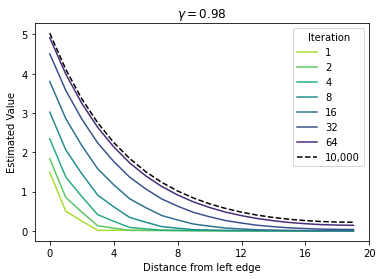

In [8]:
gamma = 0.98

# call the value iteration network
Q, V_g98 = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g098 = value_estimate_error(V_g98)

plot_1d_value_estimates(V_g98, gamma)
# plt.savefig('images/1dDrift_g98.pdf', dpi=300)

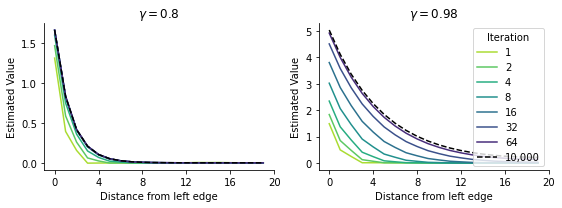

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
plot_1d_value_estimates(V_g80, 0.80, ax=axes[0], legend=False)
plot_1d_value_estimates(V_g98, 0.98, ax=axes[1], legend=True)
sns.despine()
plt.tight_layout()
plt.savefig('images/1D-statespace.pdf', dpi=300, )

  0%|          | 0/10000 [00:00<?, ?it/s]

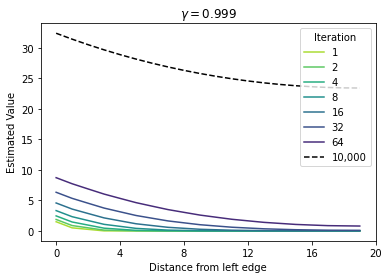

In [10]:
gamma = 0.999

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g0999 = value_estimate_error(V)


plot_1d_value_estimates(V, gamma)
# plt.savefig('images/1dDrift_g999.pdf', dpi=300)

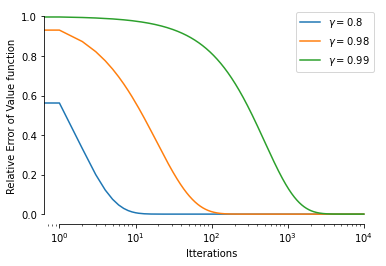

In [11]:
plt.plot(error_g08/np.max(error_g08), label=r'$\gamma = {}$'.format(0.8))
plt.plot(error_g098/np.max(error_g098), label=r'$\gamma = {}$'.format(0.98))
plt.plot(error_g0999/np.max(error_g0999), label=r'$\gamma = {}$'.format(0.99))
plt.xscale('log')
plt.legend()
plt.xlabel('Itterations')
plt.ylabel('Relative Error of Value function')
sns.despine(trim=True)
plt.savefig('images/convergence_as_function_of_gamma.pdf', dpi=300)



In [12]:
# error = simulation_utils.evaluate_policy(mcts.get_selection_policy(beta=4), optimal_policy)


# fig, ax = plt.subplots(figsize=(12, 8))
# pos  = ax.imshow(error.reshape(1, -1), cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
# plt.plot(5, 0, '*', c='r', markersize=8)
# environments.clean_up_reward_at_end(plt.gca(), n_columns)
# plt.show()



## Visualization: Adjacency Matrix
2-d lattice grid-world with 16 states




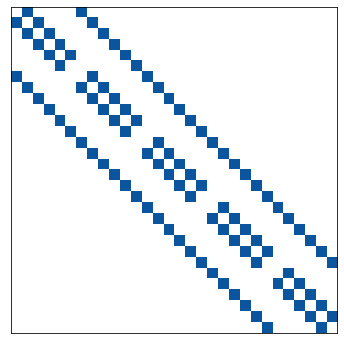

In [13]:

n_rows, n_columns = 5, 6
transition_functions = environments.make_diffision_transition_matrix(n_rows, n_columns, False)

#conver to adjacency matrix
import matplotlib
transition_functions = transition_functions > 1e-3

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(transition_functions, cmap=matplotlib.colors.ListedColormap(['White'] + sns.color_palette("Blues")),vmin=0)
ax.set_xticks([])
ax.set_yticks([])

fig.savefig('images/5x6adjacency.pdf', dpi=300)

## Example 4: Needle in a Haystack
This is designed as an example that is difficult for MCTS but easy for Value iteration. Note: these are the first simulations to derive a meaningful policy (the above were diffusion policies).


In [14]:
# define the enviornment
n_rows, n_columns = 20, 20
movement_penalty = 0
slip_probability = 0.05
random_movement_on_error = False

transition_functions, state_reward_function, optimal_policy = environments.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=movement_penalty,
    slip_probability=slip_probability,
    random_movement_on_error=random_movement_on_error
)


state_action_reward_functions = environments.get_state_action_reward_from_sucessor_rewards(
    state_reward_function, transition_functions
)


grid_shape = (n_rows, n_columns)

goal_state = 0
bottleneck_start_state = n_rows * n_columns - n_columns//2 
corner_start_state = n_rows * n_columns - 1

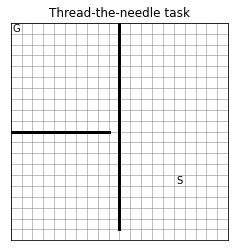

In [15]:
plt.imshow(np.zeros((n_rows, n_columns)), cmap='Greys')
environments.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

plt.gca().annotate('G', (0, 0), ha='center', va='center', c='k')
plt.gca().annotate('S', (n_rows-5, n_columns-6), ha='center', va='center', c='k')
plt.title('Thread-the-needle task')
plt.savefig('images/thread_the_needle_task.png', dpi=300)

### Value Iteration

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

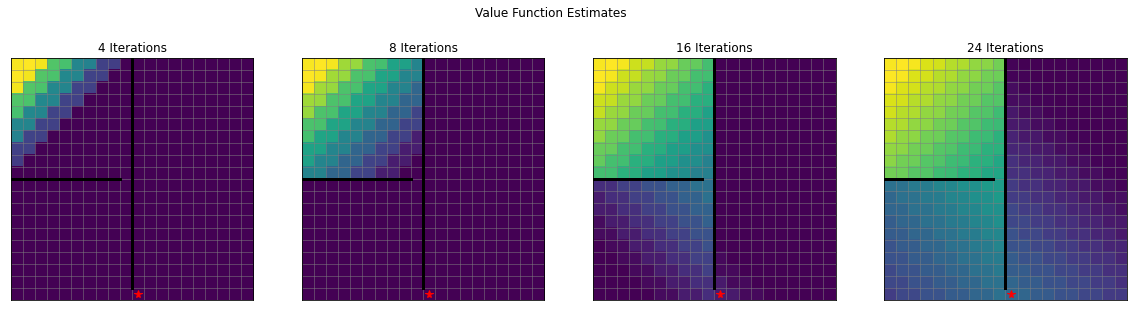

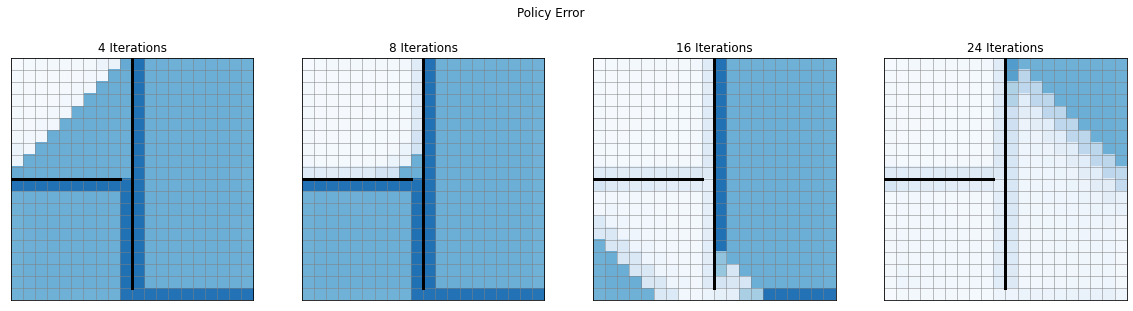

In [16]:
gamma = 0.99
beta = 5

common_model_kwargs = dict(
    transition_functions=transition_functions, 
    reward_functions=state_action_reward_functions,
    n_rows=n_rows, 
    n_columns=n_columns
)


fig_v, axes_v = plt.subplots(1, 4, figsize=(20, 5))
fig_e, axes_e = plt.subplots(1, 4, figsize=(20, 5))



# 1 iteration
def evalute_plot_vi(iterations, ax_v, ax_e):
    Q, R = ValueIterationNetwork.value_iteration(gamma=gamma, **common_model_kwargs, iterations=iterations)
    pi = softmax(Q, beta=beta)
    error = models.utils.evaluate_policy(pi, optimal_policy=optimal_policy)

    ax_v.imshow(R.reshape(n_rows, n_columns) )
    
    r, c = environments.get_position_from_state(bottleneck_start_state, n_columns)
    ax_v.plot(c, r, '*', c='r', markersize=8)
    environments.clean_up_thread_the_needle_plot(ax_v, n_columns, n_rows)
    ax_v.set_title(f"{iterations} Iterations")

    pos  = ax_e.imshow(error.reshape(grid_shape), 
                     cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
    environments.clean_up_thread_the_needle_plot(ax_e, n_columns, n_rows)
    ax_e.set_title(f"{iterations} Iterations")
    
evalute_plot_vi(4, axes_v[0], axes_e[0])
evalute_plot_vi(8, axes_v[1], axes_e[1])
evalute_plot_vi(16, axes_v[2], axes_e[2])
evalute_plot_vi(24, axes_v[3], axes_e[3])

fig_v.suptitle('Value Function Estimates')
fig_e.suptitle('Policy Error')

fig_v.savefig('images/thread_the_needle_value_function.png', dpi=300)
fig_e.savefig('images/thread_the_needle_policy_error.png', dpi=300)

In [17]:
# find the shortest path
Q, R = ValueIterationNetwork.value_iteration(gamma=gamma, **common_model_kwargs, iterations=1000)
from typing import List

def check_valid(pos, max_pos):
    return (pos > -1) and (pos < max_pos)

def get_neighbors(state: int, n_columns: int, n_rows: int) -> List[int]:
    r, c = environments.get_position_from_state(state, n_columns)
    neighbors = []
    for dr, dc in [[-1, 0], [1, 0], [0, -1], [0, 1]]:
        if check_valid(r + dr, n_rows) and check_valid(c + dc, n_columns):
            neighbors.append(
                environments.get_state_from_position(r+dr, c+dc, n_columns)
            )
    return neighbors
    
    
def find_shortest_path(state_value_function: np.ndarray, goal_state:int, start_state: int) -> np.ndarray:
    
    state = start_state
    path = []
    while state is not goal_state:
        neighbors = get_neighbors(state, n_columns, n_rows)
        values = {n: state_value_function[n] for n in neighbors if n not in path}
        state = max(values, key = values.get)
        path.append(state)
        
        
    return path

shortest_path = find_shortest_path(R, goal_state, bottleneck_start_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
%reload_ext autoreload
from models.mcts import MCTS, GridWorldNode, MctsSr

goals_state = 0


mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function ,
    exploration_weight = 2**0.5,
    max_depth = 1000,
    n_sims = 100,
    gamma = 0.98,
    
)
mcts_sr = MctsSr(**mcts_kwargs)
bottleneck_start_node = GridWorldNode(bottleneck_start_state, n_actions = 4)
corner_start_node = GridWorldNode(corner_start_state, n_actions = 4)


mcts_sr.do_rollouts(bottleneck_start_node, k=10)
# mcts_sr.do_single_rollout(bottleneck_start_node)
mcts_sr.do_single_rollout(bottleneck_start_node)

MCTS Rollouts: 100%|██████████| 10/10 [00:00<00:00, 197.09it/s]


[(GridWorldNode(state=390, n_actions=4), 0),
 (GridWorldNode(state=370, n_actions=4), 2),
 (GridWorldNode(state=371, n_actions=4), 3)]

In [19]:
mcts_sr.q[bottleneck_start_node.state]

array([4.52024002, 4.52671798, 4.51971336, 5.03338588])

In [20]:
mcts_sr.n[bottleneck_start_node.state]

array([   4.,    5.,    3., 1001.])

In [21]:
mcts_sr.q

{390: array([4.52024002, 4.52671798, 4.51971336, 5.03338588]),
 370: array([4.51939257, 4.51920542, 4.51938699, 4.51974309]),
 389: array([4.52052079, 4.52117232, 4.52276982, 4.52052079]),
 350: array([4.51920542, 4.51887248, 4.51887248, 4.51939257]),
 369: array([4.51887248, 4.51887248, 4.51887248, 4.52052079]),
 388: array([4.52117232, 4.52082115, 4.51887248, 4.51887248]),
 330: array([4.51887248, 4.51887248, 4.51887248, 4.51920542]),
 391: array([4.51887248, 4.51887248, 4.51919885, 4.51887248]),
 387: array([4.51887248, 4.51887248, 4.51887248, 4.52082115]),
 371: array([4.51887248, 4.51887248, 4.51887248, 4.51938699])}

In [22]:
mcts_sr._get_ucb_values(bottleneck_start_node)

array([3.76077692, 3.25832834, 4.54426136, 0.17132638])

In [23]:
mcts_sr._ucb_select_action(bottleneck_start_node)

2

In [24]:
mcts_sr.do_single_rollout(bottleneck_start_node)

[(GridWorldNode(state=390, n_actions=4), 2),
 (GridWorldNode(state=391, n_actions=4), 0),
 (GridWorldNode(state=371, n_actions=4), 0),
 (GridWorldNode(state=351, n_actions=4), 0)]

In [25]:
pi_star = environments.make_thread_the_needle_optimal_policy(n_rows, n_columns)
pi_star[bottleneck_start_node.state]

array([0, 1, 0, 0])

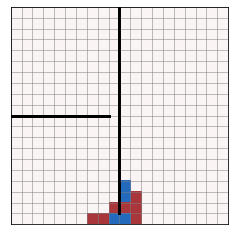

In [26]:
pi_star = environments.make_thread_the_needle_optimal_policy(n_rows, n_columns)
pi_mctssr = mcts_sr.get_policy()

def check_optimal(pi, pi_star):
    if pi == -1:
        return 0
    if pi_star[pi]:
        return 1
    return -1

fig, ax = plt.subplots()
ax.imshow(np.reshape([
    check_optimal(pi_ii, pi_star_ii) for pi_ii, pi_star_ii in zip(pi_mctssr, pi_star)],
    (n_rows, n_columns)), cmap=sns.color_palette("vlag", as_cmap=True))
environments.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)

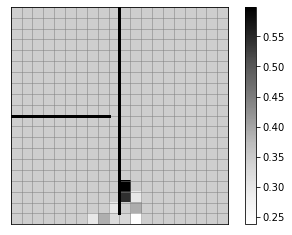

In [27]:
optimal_selection_pmf = pi_star * np.tile(1/pi_star.sum(axis=1), (4, 1)).T
mcts_selection_pmf = mcts_sr.get_selection_policy(0.4)


from scipy.stats import entropy


def scoring_function(p, q):
    # how much weight is put on a correct action?
    return np.mean(-p * np.log(q))

kl_d = [scoring_function(p, q) for p, q in zip(optimal_selection_pmf, mcts_selection_pmf)]
# kl_d = [entropy(p) for p, q in zip(optimal_selection_pmf, mcts_selection_pmf)]


fig, ax = plt.subplots()

neg = ax.imshow(np.reshape(kl_d, (n_rows, n_columns)), cmap='Greys')
environments.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)
plt.colorbar(neg, ax=ax)

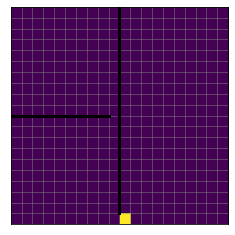

In [28]:
fig, ax = plt.subplots()

ax.imshow(mcts_sr.get_node_visitations().reshape(n_rows, n_columns))
environments.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)

In [29]:
from scipy.special import kl_div
kl_div(optimal_selection_pmf, mcts_selection_pmf).shape

(400, 4)

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'mcts' is not defined

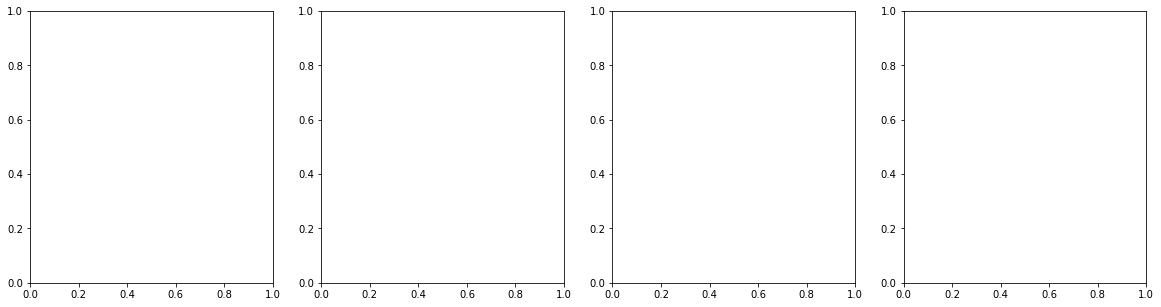

In [30]:
def get_sucessor_from_path(path, n_rows, n_columns, gamma=0.99):
    M = np.zeros(n_rows * n_columns)
    for ii, node in enumerate(path):
        M[node.state] += 1 * (gamma ** ii)
    return M


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
action_key = {0: 'Up', 1: 'Left', 2:"Right", 3:"Down"}

for a in range(4):
    successors = []
    for ii in tqdm(range(100)):
        reward, path = mcts._single_sim(bottleneck_start_node, a, return_path=True)
        M = get_sucessor_from_path(path, n_rows, n_columns)
        successors.append(M)
    successors = np.mean(successors, axis=0)

    axes[a].imshow(successors.reshape(grid_shape))
    environments.clean_up_thread_the_needle_plot(axes[a], n_columns, n_rows)
    axes[a].set_title(action_key[a])
fig.suptitle('Successor representation for MCTS simulations')

In [ ]:
start_node_corner = GridWorldNode(n_rows * n_columns - 1, n_actions = 4)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
action_key = {0: 'Up', 1: 'Left', 2:"Right", 3:"Down"}

for a in range(4):
    successors = []
    for ii in tqdm(range(100)):
        reward, path = mcts._single_sim(start_node_corner, a, return_path=True)
        M = get_sucessor_from_path(path, n_rows, n_columns)
        successors.append(M)
    successors = np.mean(successors, axis=0)

    axes[a].imshow(successors.reshape(grid_shape))
    environments.clean_up_thread_the_needle_plot(axes[a], n_columns, n_rows)
    axes[a].set_title(action_key[a])
fig.suptitle('Successor representation for MCTS simulations')

In [ ]:
k = 100

action_u_simulations = np.array([mcts.simulate(bottleneck_start_node, 0, k=1) for _ in tqdm(range(k))])
action_l_simulations = np.array([mcts.simulate(bottleneck_start_node, 1, k=1) for _ in tqdm(range(k))])
action_r_simulations = np.array([mcts.simulate(bottleneck_start_node, 2, k=1) for _ in tqdm(range(k))])
action_d_simulations = np.array([mcts.simulate(bottleneck_start_node, 3, k=1) for _ in tqdm(range(k))])


df = pd.DataFrame({
    'Simulated Return': np.concatenate([
        action_u_simulations,
        action_l_simulations,
        action_r_simulations,
        action_d_simulations
    ]),
    'Starting Action': 
        ['Up'] * k
        + ["Left"] * k
        + ["Right"] * k
        + ["Down"] * k
})
print(df.groupby('Starting Action').mean())
print(df.groupby('Starting Action').std())

In [ ]:
sns.catplot(data=df, y='Simulated Return', x='Starting Action', kind='bar')

In [ ]:
from numpy.random import choice

def bootstrap_prob_correct_simulation(_df, bootstrap_samples = 100):
    up = np.array(_df.loc[df['Starting Action'] == 'Up', 'Simulated Return'])
    down = np.array(_df.loc[df['Starting Action'] == 'Down', 'Simulated Return'])
    left = np.array(_df.loc[df['Starting Action'] == 'Left', 'Simulated Return'])
    right = np.array(_df.loc[df['Starting Action'] == 'Right', 'Simulated Return'])

    def draw_sample(_df, k, bootstrap_samples = 2):
        values = []
        for ii in range(bootstrap_samples):
            v_u = np.mean([choice(up) for _ in range(k)])
            v_d = np.mean([choice(down) for _ in range(k)])
            v_l = np.mean([choice(left) for _ in range(k)])
            v_r = np.mean([choice(right) for _ in range(k)])

            values.append(v_l > np.max([v_d, v_r, v_u]))

        return np.mean(values)

    return np.array([
        draw_sample(df, ii, bootstrap_samples) for ii in tqdm(range(1, 100))
    ])



probability_correct_simulation_direction_bottleneck = bootstrap_prob_correct_simulation(df)

plt.plot(probability_correct_simulation_direction_bottleneck)
plt.xlabel('Number of Simulation')
plt.ylabel('Probability ')
sns.despine()

In [ ]:
# pick a different start state

k = 100

action_u_simulations = np.array([mcts.simulate(start_node_corner, 0, k=1) for _ in tqdm(range(k))])
action_l_simulations = np.array([mcts.simulate(start_node_corner, 1, k=1) for _ in tqdm(range(k))])
action_r_simulations = np.array([mcts.simulate(start_node_corner, 2, k=1) for _ in tqdm(range(k))])
action_d_simulations = np.array([mcts.simulate(start_node_corner, 3, k=1) for _ in tqdm(range(k))])


df_corner = pd.DataFrame({
    'Simulated Return': np.concatenate([
        action_u_simulations,
        action_l_simulations,
        action_r_simulations,
        action_d_simulations
    ]),
    'Starting Action': 
        ['Up'] * k
        + ["Left"] * k
        + ["Right"] * k
        + ["Down"] * k
})
print(df_corner.groupby('Starting Action').mean())
print(df_corner.groupby('Starting Action').std())

sns.catplot(data=df_corner, y='Simulated Return', x='Starting Action', kind='bar')

In [ ]:
probability_correct_simulation_direction_bottleneck = bootstrap_prob_correct_simulation(
    df, bootstrap_samples=1000)
probability_correct_simulation_direction_corner = bootstrap_prob_correct_simulation(
    df_corner, bootstrap_samples=1000)


plt.plot(probability_correct_simulation_direction_bottleneck, label='Bottleneck')
plt.plot(probability_correct_simulation_direction_corner, label='Corner')


plt.xlabel('Number of Simulation')
plt.ylabel('Probability ')
plt.legend(title='Start Location')
sns.despine()

In [ ]:
# mcts.get_simulation_depth(start_node_corner)
shortest_path = find_shortest_path(R, goal_state, start_node_corner.state)

mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function ,
    max_depth = 200000,
    n_sims = 1000,
    gamma = 0.99,
    
)
mcts = MCTS(**mcts_kwargs)

def get_average_simulation_depths(path, n_samples=1):
    
    depths = []
    for ii in tqdm(range(n_samples)):
        for jj, state in enumerate(path):
            node = GridWorldNode(state, n_actions=4)
            depths.append({
                'distance from start': jj,
                'state': state,
                'iteration': ii,
                'depth': mcts.get_simulation_depth(node)
            })
            
    return pd.DataFrame(depths)

depths = get_average_simulation_depths([s for s in reversed(shortest_path)], n_samples=250)

In [ ]:

from scipy.stats import trim_mean
sns.relplot(data=depths, x='distance from start', y='depth', kind='line', estimator=np.median)
plt.axvline(18.5, c='k', ls=':')
plt.axvline(28.5, c='k', ls=':')

# plt.gca().set_yscale('log')


In [ ]:

from scipy.stats import trim_mean
sns.relplot(data=depths, x='distance from start', y='depth', kind='line', estimator=np.mean)
plt.axvline(18.5, c='k', ls=':')
plt.axvline(28.5, c='k', ls=':')



In [ ]:
counts = np.zeros(n_rows * n_columns, dtype=int)
for state in depths.groupby('state').median().index:
    counts[state] = depths.loc[state, 'depth']
plt.imshow(counts.reshape(grid_shape)>0)
environments.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

In [ ]:
counts = np.zeros(n_rows * n_columns, dtype=int)
counts[189] = 1
counts[209] = 1
counts[229] = 1
plt.imshow(counts.reshape(grid_shape))
environments.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

In [ ]:
depths.groupby('state').median()

In [ ]:
t = environments.make_thread_the_needle_diffusion_transitions(n_rows, n_columns, False)
m = np.linalg.inv(1 - 0.995 * t)

In [ ]:
plt.imshow(m[1, :].reshape(n_rows, n_columns))

In [ ]:
plt.imshow(m[399, :].reshape(n_rows, n_columns))
plt.colorbar()

In [ ]:
gamma
